In [32]:
from datetime import datetime
from typing import Dict, Union

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from siglab_py.util.trading_util import calc_eff_trailing_sl

https://norman-lm-fung.medium.com/gradually-tightened-trailing-stops-f7854bf1e02b

How to use calc_eff_trailing_sl?
    if loss_trailing>=effective_tp_trailing_percent and pnl_percent_notional > tp_min_percent:
            Fire trailing stops and take profit.

What's 'loss_trailing'? 'loss_trailing' is essentially pnl drop from max_unrealized_pnl_live.

    Say, when trade started off:
        unrealized_pnl_live = $80
        max_unrealized_pnl_live = $100
        loss_trailing = (1 - unrealized_pnl_live/max_unrealized_pnl_live) = (1-80/100) = 0.2 (Or 20%)

    If pnl worsen:
        unrealized_pnl_live = $40
        max_unrealized_pnl_live = $100
        loss_trailing = (1 - unrealized_pnl_live/max_unrealized_pnl_live) = (1-40/100) = 0.6 (Or 60%)

In [33]:
tp_min_percent : float = 0 # Target minimum TP in percent
tp_max_percent : float = 3 # Target maximum TP in percent
sl_percent_trailing : float = 50 # Trailing stop loss in percent
default_effective_tp_trailing_percent : float = float('inf') # inf: Essentially means don't fire trailing stop if pnl < tp_min_percent

pnl_percent_notional : float = 0 # Trade's current pnl in percent.
pnl_trailing_sl_map = {}
for i in range(100):
    effective_tp_trailing_percent = calc_eff_trailing_sl(
        tp_min_percent = tp_min_percent,
        tp_max_percent = tp_max_percent,
        sl_percent_trailing = sl_percent_trailing,
        pnl_percent_notional = pnl_percent_notional, # In this example, pnl_percent_notional is motonically increasing
        default_effective_tp_trailing_percent = default_effective_tp_trailing_percent,
        linear=False,
        pow=5
    )
    pnl_trailing_sl_map[pnl_percent_notional] = round(effective_tp_trailing_percent, 2)
    pnl_percent_notional = round(pnl_percent_notional + 0.1, 2)
    if pnl_percent_notional>5:
        break

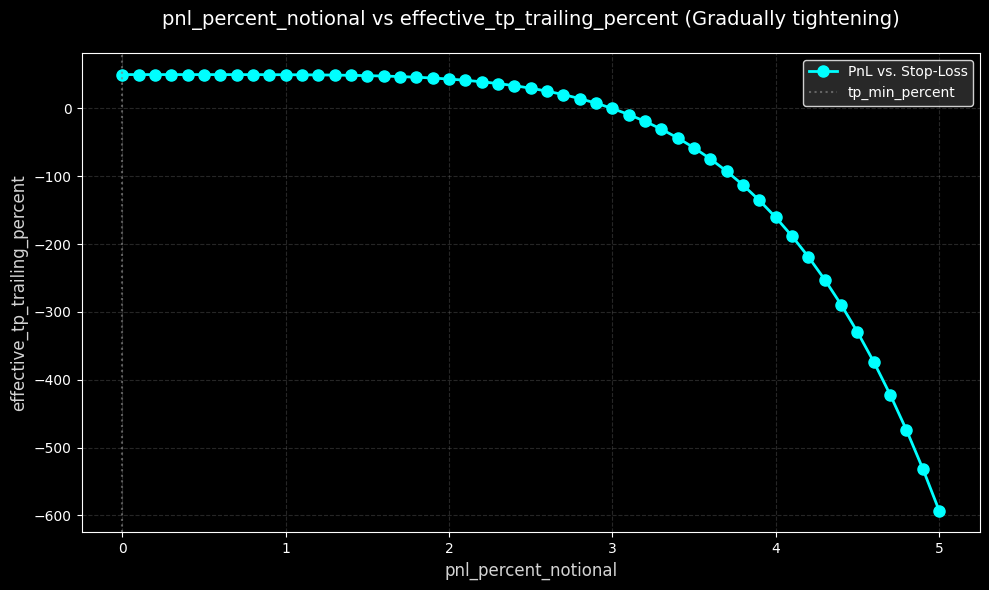

In [34]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    list(pnl_trailing_sl_map.keys()), 
    list(pnl_trailing_sl_map.values()), 
    marker='o', 
    linestyle='-', 
    color='cyan',
    markersize=8,
    linewidth=2,
    label="PnL vs. Stop-Loss"
)

ax.set_title(
    "pnl_percent_notional vs effective_tp_trailing_percent (Gradually tightening)", 
    fontsize=14, 
    color='white', 
    
    pad=20
)
ax.set_xlabel(
    "pnl_percent_notional", 
    fontsize=12, 
    color='lightgray'
)
ax.set_ylabel(
    "effective_tp_trailing_percent", 
    fontsize=12, 
    color='lightgray'
)

ax.grid(
    color='gray', 
    linestyle='--', 
    alpha=0.3
)

ax.axvline(
    x=tp_min_percent, 
    color='grey', 
    linestyle=':', 
    alpha=0.7, 
    label="tp_min_percent"
)

ax.legend(
    facecolor='#333333',
    edgecolor='white',
    fontsize=10
)

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.tight_layout()
plt.show()


In [6]:
def _lookup_effective_tp_trailing_percent(
        current_pnl_percent_notional : float
):
    effective_tp_trailing_percent = -1
    for pnl_percent_notional in pnl_trailing_sl_map:
        if current_pnl_percent_notional>=pnl_percent_notional:
            effective_tp_trailing_percent = pnl_trailing_sl_map[pnl_percent_notional]
    return effective_tp_trailing_percent
order_notional = 100_000
actual_pnl_history = [ 
    0, 
    250, 
    500, 
    750, 
    1000, 
    1250, 
    1500, 
    1250, 
    900  # When pnl retrace too much, you'd fire trailing stops.
]
max_unrealized_pnl_live = 0
actual_pnl_percent_history = []
loss_trailing_history = []
effective_tp_history = []
for unrealized_pnl_live in actual_pnl_history:
    if unrealized_pnl_live>max_unrealized_pnl_live:
        max_unrealized_pnl_live = unrealized_pnl_live
    if max_unrealized_pnl_live>0:
        unrealized_pnl_live_percent = round(unrealized_pnl_live/order_notional * 100, 2)
        max_unrealized_pnl_live_percent = round(max_unrealized_pnl_live/order_notional * 100, 2)
        loss_trailing = round( (1 - unrealized_pnl_live_percent/max_unrealized_pnl_live_percent) * 100, 2)
        effective_tp_trailing_percent = _lookup_effective_tp_trailing_percent(max_unrealized_pnl_live_percent)

        actual_pnl_percent_history.append(unrealized_pnl_live_percent)
        loss_trailing_history.append(loss_trailing)
        effective_tp_history.append(effective_tp_trailing_percent)

        print(f"unrealized_pnl_live_percent: {unrealized_pnl_live_percent}, max_unrealized_pnl_live_percent: {max_unrealized_pnl_live_percent}, loss_trailing: {loss_trailing}, effective_tp_trailing_percent: {effective_tp_trailing_percent}, trailing stop fired: {'Y' if loss_trailing>=effective_tp_trailing_percent else 'N'}")
        

unrealized_pnl_live_percent: 0.25, max_unrealized_pnl_live_percent: 0.25, loss_trailing: 0.0, effective_tp_trailing_percent: 50.0, trailing stop fired: N
unrealized_pnl_live_percent: 0.5, max_unrealized_pnl_live_percent: 0.5, loss_trailing: 0.0, effective_tp_trailing_percent: 49.95, trailing stop fired: N
unrealized_pnl_live_percent: 0.75, max_unrealized_pnl_live_percent: 0.75, loss_trailing: 0.0, effective_tp_trailing_percent: 49.74, trailing stop fired: N
unrealized_pnl_live_percent: 1.0, max_unrealized_pnl_live_percent: 1.0, loss_trailing: 0.0, effective_tp_trailing_percent: 48.44, trailing stop fired: N
unrealized_pnl_live_percent: 1.25, max_unrealized_pnl_live_percent: 1.25, loss_trailing: 0.0, effective_tp_trailing_percent: 46.11, trailing stop fired: N
unrealized_pnl_live_percent: 1.5, max_unrealized_pnl_live_percent: 1.5, loss_trailing: 0.0, effective_tp_trailing_percent: 38.13, trailing stop fired: N
unrealized_pnl_live_percent: 1.25, max_unrealized_pnl_live_percent: 1.5, loss

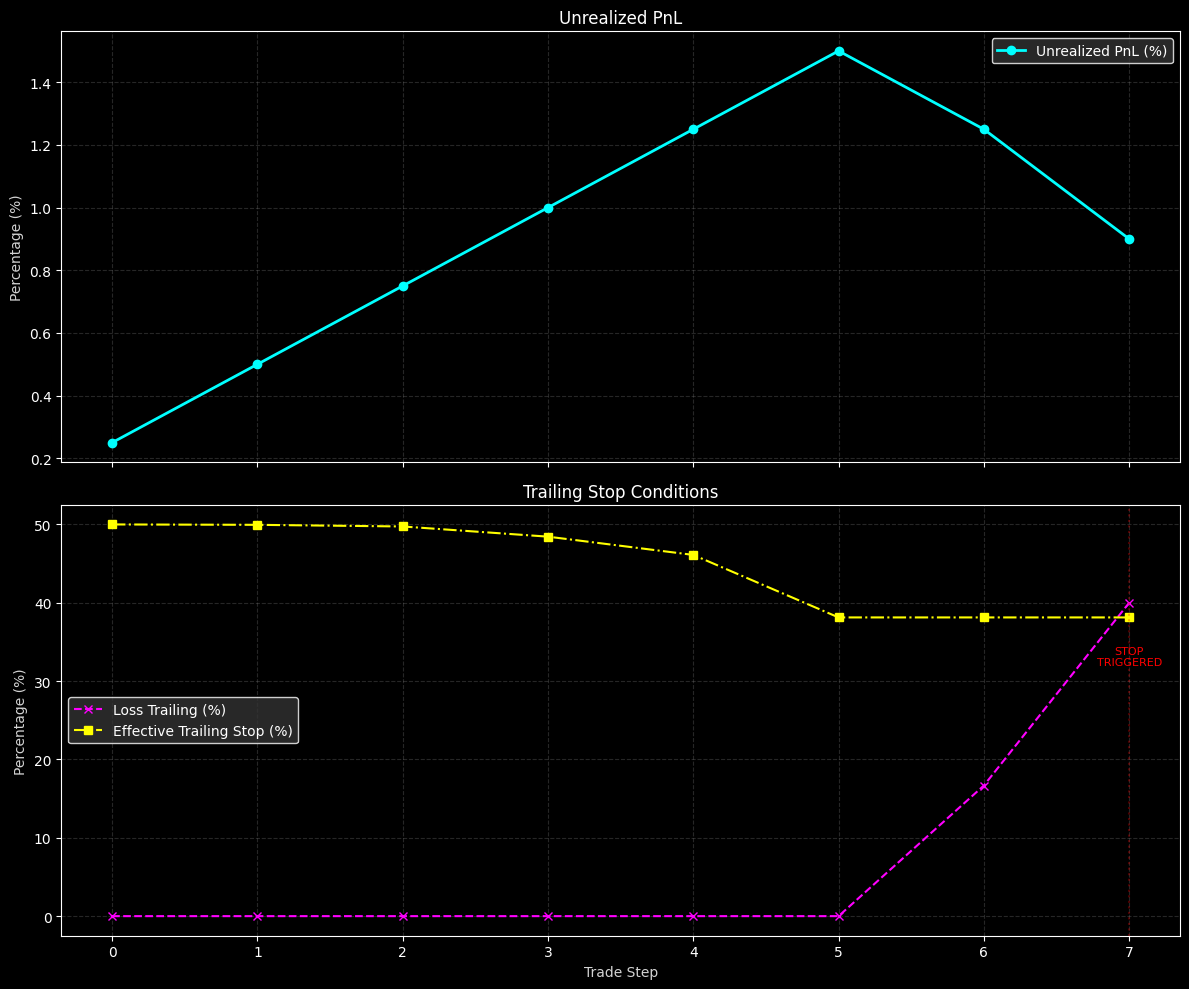

In [7]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1]}, sharex=True)

for pnl_percent in actual_pnl_percent_history:
    if pnl_percent > max_unrealized_pnl_live_percent:
        max_unrealized_pnl_live_percent = pnl_percent
    loss_trailing = round((1 - pnl_percent/max_unrealized_pnl_live_percent)*100, 2) if max_unrealized_pnl_live_percent > 0 else 0
    effective_tp_trailing_percent = _lookup_effective_tp_trailing_percent(max_unrealized_pnl_live_percent) if max_unrealized_pnl_live_percent > 0 else 0
    
ax1.plot(actual_pnl_percent_history, label='Unrealized PnL (%)', color='cyan', marker='o', linewidth=2)
ax2.plot(loss_trailing_history, label='Loss Trailing (%)', color='magenta', marker='x', linestyle='--')
ax2.plot(effective_tp_history, label='Effective Trailing Stop (%)', color='yellow', marker='s', linestyle='-.')

for i, (loss, effective_tp_trailing_percent) in enumerate(zip(loss_trailing_history, effective_tp_history)):
    if loss >= effective_tp_trailing_percent and effective_tp_trailing_percent > 0:
        ax2.axvline(x=i, color='red', alpha=0.3, linestyle=':')
        ax2.text(x=i, y=max(loss_trailing_history)*0.8, s='STOP\nTRIGGERED', color='red', ha='center', fontsize=8)

ax1.set_title("Unrealized PnL", fontsize=12, color='white')
ax1.set_ylabel("Percentage (%)", fontsize=10, color='lightgray')
ax1.grid(color='gray', linestyle='--', alpha=0.3)
ax1.legend(facecolor='#333333', edgecolor='white')

ax2.set_title("Trailing Stop Conditions", fontsize=12, color='white')
ax2.set_xlabel("Trade Step", fontsize=10, color='lightgray')
ax2.set_ylabel("Percentage (%)", fontsize=10, color='lightgray')
ax2.grid(color='gray', linestyle='--', alpha=0.3)
ax2.legend(facecolor='#333333', edgecolor='white')

plt.tight_layout()
plt.show()